In [1]:
# Imports
import torch
import torch.nn as nn
torch.cuda.empty_cache()

from utils import *
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from typing import Tuple, List, Any, TypedDict

IMG_SIZE = 518
PATCH_SIZE  = 14
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384

transform = get_input_transform(520, IMG_SIZE)

In [2]:
from high_res import HighResDV2
shifts = [1, 3, 5, 7]
net = HighResDV2("dinov2_vits14", shifts, pattern="Moore", dtype=torch.float32, pca_each=True)
net.cuda()
# net.eval() changing this has a weird impact on my features vs without
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [3]:
plane_tensor, plane_img = load_image("data/plane.jpg", transform)
plane_tensor = plane_tensor.to('cuda')

Here we visualise the data processing/pixel shift by looking at the last pixel shift image and subtracting the original - depending on which neighbourhood is used (Neumann vs Moore) this shoould highlight either vertical gradients or diagonal gradients.

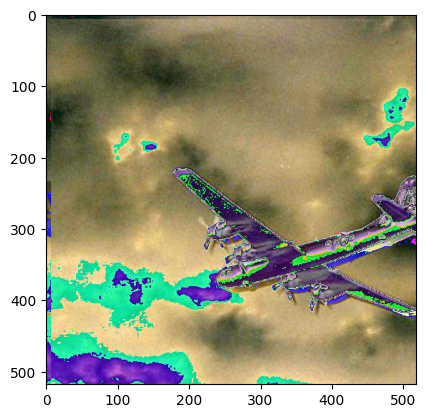

In [4]:
shifted_img_tensors = net.get_shifted_img_batch(plane_tensor).detach().cpu()
img = to_img(unnormalize(shifted_img_tensors[-1, :, :, :]) - plane_tensor.cpu())
plt.imshow(img)

In [5]:
low_res_plane_features = net.low_res_features(plane_tensor.unsqueeze(0))
low_res_plane_pca = net.pca(low_res_plane_features, 70).detach().cpu().squeeze(0).numpy()[:, :3]
high_res_plane_pca = net(plane_tensor).detach().cpu().squeeze(0).numpy()

Here we compare the resolution of the features: first the DINOv2 features at 37x37, then those features upsampled to 518x518 with bilinear antialiased interpolation and finally the 'high-res' version from our model. We see that the high-res model is different to the upsampling and contains high frequency features.

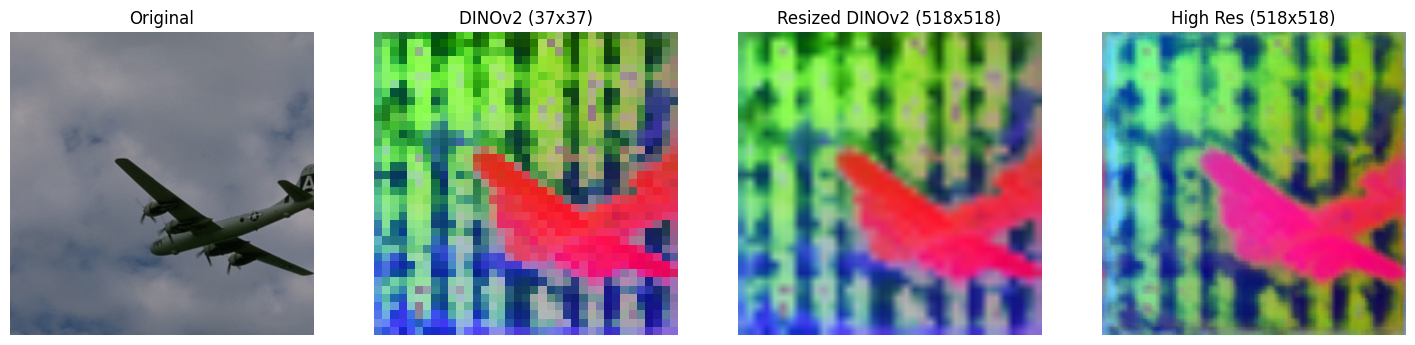

In [6]:
high_res_img = high_res_plane_pca.transpose(1, 2, 0)[:, :, :3]
normed = normalize_pca_img(high_res_img)
#print(normed[:10, :10, :3])
fig, axs = plt.subplots(1, 4)
fig.set_size_inches(18, 8)

low_res_features = normalise_pca(low_res_plane_pca).reshape(PATCH_H, PATCH_W, 3)
rescaled = (low_res_features * 255).astype(np.uint8)
low_res_feature_img = Image.fromarray(rescaled, mode="RGB")
low_res_upscale = low_res_feature_img.resize((IMG_SIZE, IMG_SIZE), resample=Image.BILINEAR)


axs[0].imshow(plane_img)
axs[1].imshow(low_res_features)
axs[2].imshow(low_res_upscale)
axs[3].imshow(normed[:, :, :])
titles = ["Original", f"DINOv2 ({PATCH_H}x{PATCH_W})", f"Resized DINOv2 ({IMG_SIZE}x{IMG_SIZE})", f"High Res ({IMG_SIZE}x{IMG_SIZE})"]
for i, ax in enumerate(axs):
    ax.set_axis_off()
    ax.set_title(titles[i])

To repeat our dog foreground feature comparison let's load the data and find the foreground/background cutoff:

(array([184., 185., 141., 131., 145., 181., 112.,  44.,  88., 158.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

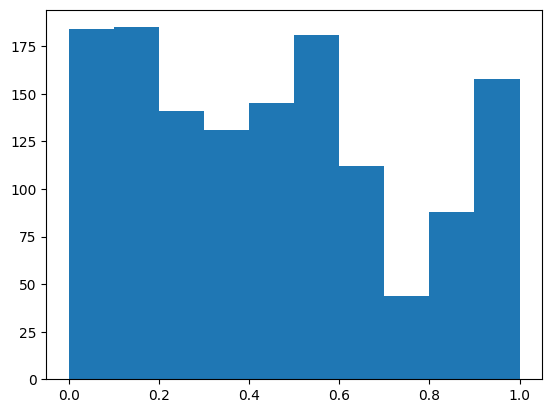

In [26]:
dog2_tensor, dog2_img = load_image("data/d1.jpg", transform)
dog2_tensor = dog2_tensor.to('cuda')

low_res_dog_2_features = net.low_res_features(dog2_tensor.unsqueeze(0))
low_res_dog_2_pca = net.pca(low_res_dog_2_features, 3).squeeze(0).detach().cpu().numpy()
low_res_dog_2_pca_norm = normalise_pca(low_res_dog_2_pca)
plt.hist(low_res_dog_2_pca_norm[:, 0])


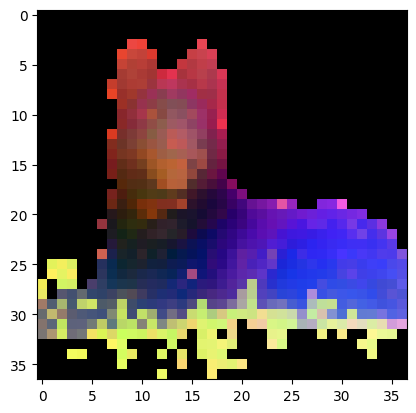

In [27]:
foreground_mask = np.where(low_res_dog_2_pca_norm[:, 0] < 0.4, 1, 0).reshape(PATCH_H, PATCH_W, 1)
plane_pca_fg = low_res_dog_2_pca_norm.reshape(PATCH_H, PATCH_W, 3) * foreground_mask
plane_pca_fg_norm = normalize_pca_img(plane_pca_fg)
plt.imshow(plane_pca_fg_norm)

A threshold of 0.33 on the normalised PCA seems to work well so we'll use that going forward.

In [37]:
dog_tensors, dog_imgs,  = [], []
dog_features_fg, dog_features_fg_lr = [], []
fg_masks, fg_masks_lr = [], []

#net.pca_each = True
net.pca_each = False
thresholds = ((False, 0.4), (False, 0.4), (True, 0.80))

 
for i in range(1, 4):
    tensor, img = load_image(f"data/d{i}.jpg", transform)
    c, h, w = tensor.shape
    tensor = tensor.cuda()
    dog_tensors.append(tensor)
    dog_imgs.append(img)

    high_res_features: torch.Tensor = net(tensor).squeeze(0)
    high_res_feature_arr = high_res_features.detach().cpu().numpy()
    high_res_feature_arr = high_res_feature_arr.transpose(1, 2, 0)
    high_res_features_flat = high_res_feature_arr.reshape((h * w, net.feat_dim))

    low_res_features: torch.Tensor = net.low_res_features(tensor.unsqueeze(0)).squeeze(0)
    low_res_feature_arr = low_res_features.detach().cpu().numpy()
    #low_res_feature_arr = low_res_feature_arr.transpose(1, 2, 0)
    low_res_features_flat = low_res_feature_arr.reshape((PATCH_H * PATCH_W, net.feat_dim))

    temp_PCA = PCA(n_components=3)
    temp_PCA.fit(high_res_features_flat)
    dog_pca = temp_PCA.transform(high_res_features_flat)

    temp_PCA.fit(low_res_features_flat)
    dog_pca_lr = temp_PCA.transform(low_res_features_flat)

    norm_dog_pca = normalise_pca(dog_pca)
    norm_dog_pca_lr = normalise_pca(dog_pca_lr)
    print(dog_pca.shape, high_res_features_flat.shape, norm_dog_pca.shape)

    gt, t = thresholds[i - 1]
    if gt == True:
        fg = np.where(norm_dog_pca[:, 0] > t)
        fg_mask = np.where(norm_dog_pca[:, 0] > t, 1, 0)
        fg_lr = np.where(norm_dog_pca_lr[:, 0] > t)
        fg_mask_lr = np.where(norm_dog_pca_lr[:, 0] > t, 1, 0)
    else:
        fg = np.where(norm_dog_pca[:, 0] < t)
        fg_mask = np.where(norm_dog_pca[:, 0] < t, 1, 0)
        fg_lr = np.where(norm_dog_pca_lr[:, 0] < t)
        fg_mask_lr = np.where(norm_dog_pca_lr[:, 0] < t, 1, 0)

    fg_masks.append(fg_mask)
    dog_features_fg.append(high_res_features_flat[fg])
    fg_masks_lr.append(fg_mask_lr)
    dog_features_fg_lr.append(low_res_features_flat[fg_lr])

(268324, 3) (268324, 384) (268324, 3)
(268324, 3) (268324, 384) (268324, 3)
(268324, 3) (268324, 384) (268324, 3)


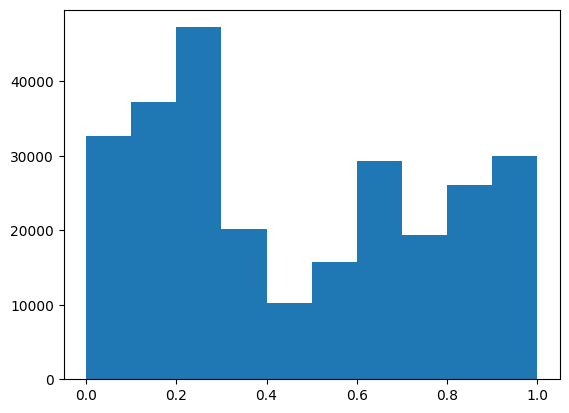

In [10]:
plt.hist(norm_dog_pca[:, 0])
pass

(283067, 384)
(115765, 3) (268324, 3) 115765 (115765, 384)
(137448, 3) (268324, 3) 137448 (137448, 384)
(29854, 3) (268324, 3) 29854 (29854, 384)


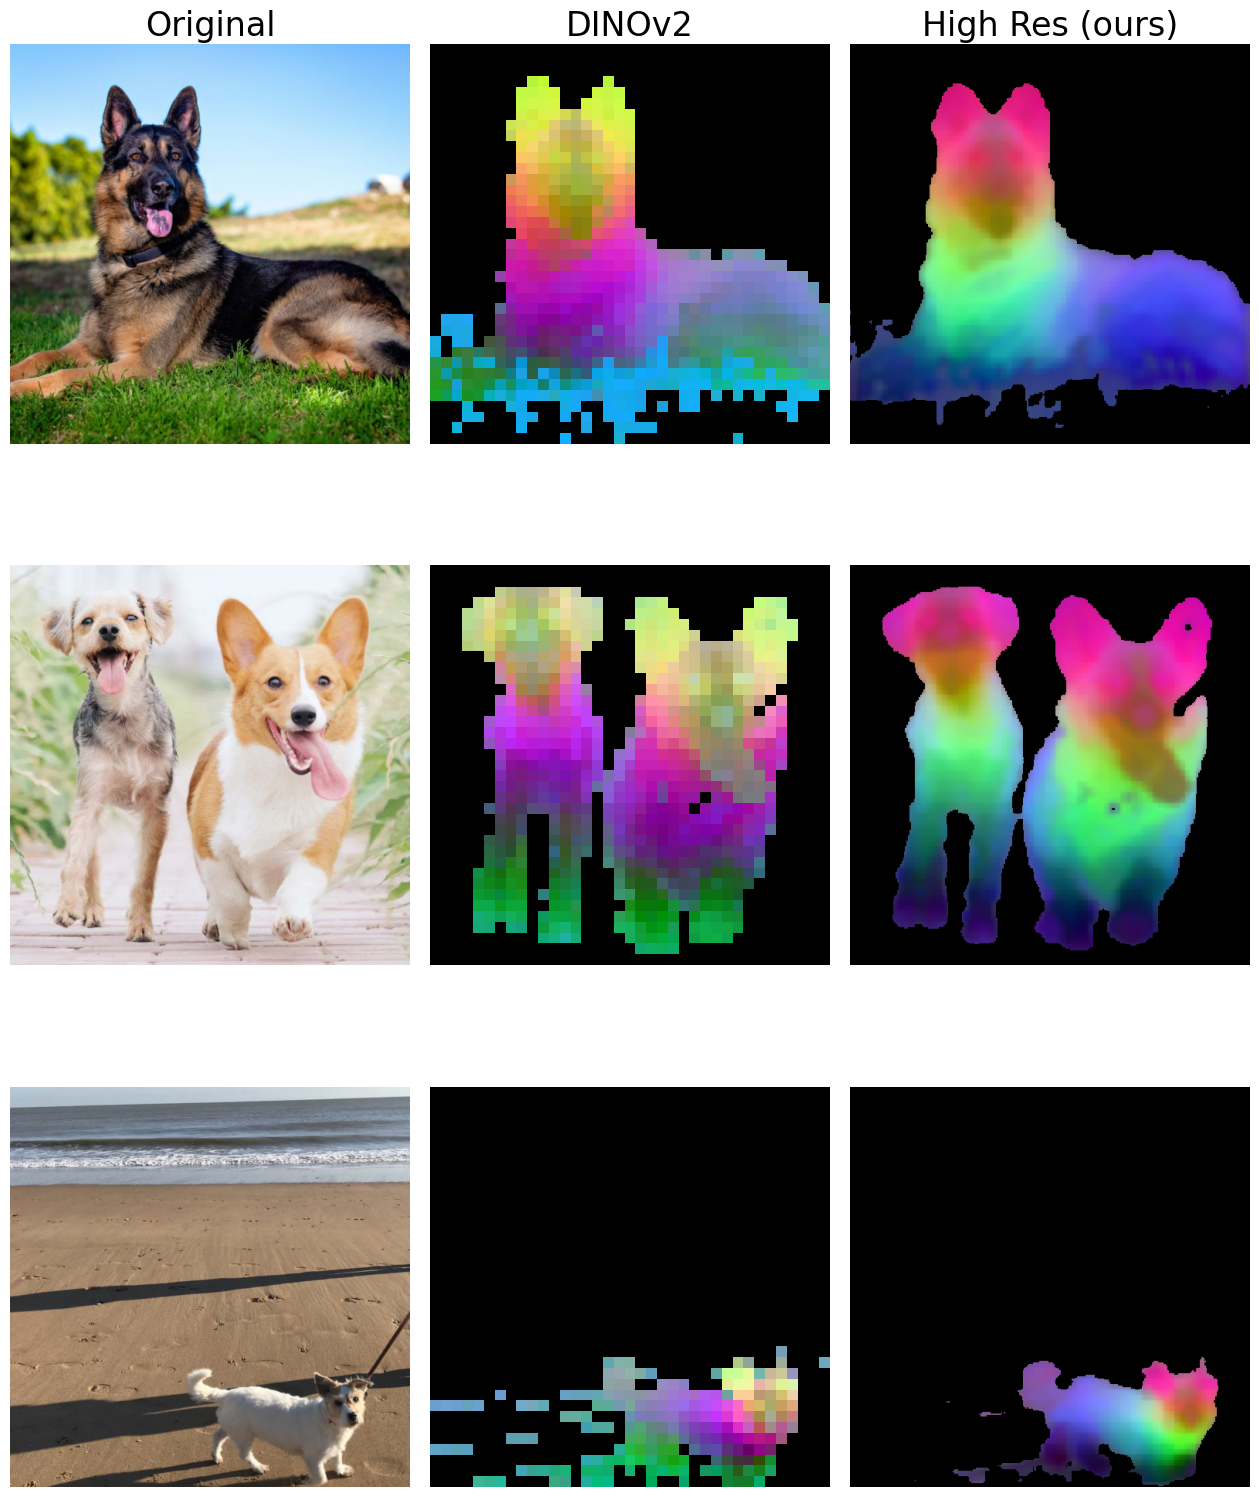

In [48]:
concat_features_flat = np.concatenate(dog_features_fg, 0)
print(concat_features_flat.shape)
shared_pca = PCA(n_components=3)
shared_pca.fit(concat_features_flat)

concat_features_flat_lr = np.concatenate(dog_features_fg_lr, 0)
shared_pca_lr = PCA(n_components=3)
shared_pca_lr.fit(concat_features_flat_lr)

fig, axs = plt.subplots(3, 3)
fig.set_size_inches(16, 20)
#plt.tight_layout()
for i, feat in enumerate(dog_features_fg):
    shared_repr = shared_pca.transform(feat)
    norm_fg_pca = normalise_pca(shared_repr)
    out = np.zeros((IMG_SIZE * IMG_SIZE, 3))
    nonzero_idx = 0
    print(norm_fg_pca.shape, out.shape, np.sum(fg_masks[i]), feat.shape)
    # slow implementation but w/e
    for j, val in enumerate(fg_masks[i]):
        if val == 1:
            out[j, :] = norm_fg_pca[nonzero_idx, :]
            nonzero_idx += 1
    
    shared_repr_lr = shared_pca_lr.transform(dog_features_fg_lr[i])
    norm_fg_pca_lr = normalise_pca(shared_repr_lr)
    out_lr = np.zeros((PATCH_H * PATCH_W, 3))

    nonzero_idx = 0
    for j, val in enumerate(fg_masks_lr[i]):
        if val == 1:
            out_lr[j, :] = norm_fg_pca_lr[nonzero_idx, :]
            nonzero_idx += 1

    if i == 0:
        axs[i, 0].set_title("Original", fontsize=24)
        axs[i, 1].set_title("DINOv2", fontsize=24)
        axs[i, 2].set_title("High Res (ours)", fontsize=24)

    axs[i, 0].imshow(dog_imgs[i])
    axs[i, 0].set_axis_off()
    axs[i, 1].imshow(out_lr.reshape(PATCH_H, PATCH_W, 3))
    axs[i, 1].set_axis_off()
    axs[i, 2].imshow(out.reshape(IMG_SIZE, IMG_SIZE, 3))
    axs[i, 2].set_axis_off()

plt.subplots_adjust(wspace=0.05, hspace=0.05)

TODO: add l2 distance between resized dino v2 features and the high-res features (i.e is there a big difference?)


TODO: comparison as shift is increased/neighbourhood is changed?

TODO: k means unsupervised phase segmentation on SOFC?